In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import statsmodels.api as sm
import matplotlib.patheffects as PathEffects

#import the data
df_s=pd.read_excel('/Users/luxueqi/Desktop/gmo_analysis_data.xlsx',sheet_name='signals',index_col=0)
df_r=pd.read_excel('/Users/luxueqi/Desktop/gmo_analysis_data.xlsx',sheet_name='returns (total)',index_col=0)
df_rf=pd.read_excel('/Users/luxueqi/Desktop/gmo_analysis_data.xlsx',sheet_name='risk-free rate',index_col=0)

### Question 1

In [110]:
spy = df_r[['SPY']]
#from 2023:
#drop null:
signals = df_s.shift(1).dropna()
spy = spy.loc[signals.index]

# build the forecasted returns (for question 2)
#expanding:
forecast_df = spy.expanding().mean().shift(1).dropna()
forecast_df.columns = ['Mean']

def reg(name):
    
    x = signals[name]
    model = sm.OLS(spy, sm.add_constant(x)).fit()
    summary = dict()
    summary["alpha"] = model.params["const"]
    summary["beta"] = model.params[1]
    summary["r-squared"] = model.rsquared
    forecaseted_r = model.params[0] + model.params[1] * df_s[name]
    return(pd.DataFrame(summary, index=[name]),forecaseted_r)

dp_r, forecast_df['DP']=reg('DP')
ep_r, forecast_df['EP']=reg('EP')
print(dp_r)
print(ep_r)

# Multi-variate regression.
multi_regr = sm.OLS(spy, sm.add_constant(signals)).fit()
summary_m = dict()
summary_m["alpha"] = multi_regr.params["const"]
summary_m["DP beta"] = multi_regr.params[1]
summary_m["EP beta"] = multi_regr.params[2]
summary_m["10Y beta"] = multi_regr.params[3]
summary_m["r-squared"] = multi_regr.rsquared
display(summary_m)
forecast_df['Multi'] = multi_regr.params[0] + multi_regr.params[1] * df_s['DP'] + multi_regr.params[2] * df_s['EP'] + multi_regr.params[3] * df_s['US10Y']



       alpha      beta  r-squared
DP -0.012297  0.011358   0.008732
       alpha      beta  r-squared
EP -0.003165  0.002578   0.005001


{'alpha': -0.014647549549770076,
 'DP beta': 0.00911421246369918,
 'EP beta': 0.002147366861593744,
 '10Y beta': -0.0008733178210935706,
 'r-squared': 0.013277323915255157}

### Question 2

In [111]:
#from 2023
forecast_df.dropna(inplace=True)
forecast_df['Actuals'] = spy['SPY']
forecast_df['Risk-Free'] = df_rf['US3M']

#set the scale
forecast_wt = forecast_df * 100
forecast_model = forecast_wt[['DP', 'EP', 'Multi']]
#w_t * forecasted spy return:
forecast_model = forecast_model.multiply(forecast_df['Actuals'], axis=0)
forecast_model['Actuals'] = forecast_df['Actuals']

#from week2:
def mdd_timeseries(rets):
    cum_rets = (1 + rets).cumprod()
    rolling_max = cum_rets.cummax()
    drawdown = (cum_rets - rolling_max) / rolling_max
    return cum_rets,rolling_max,drawdown

def performance(dataframe):

    #mean
    df_mean = dataframe.mean() * 12
    #volatility
    df_vol = dataframe.std() * np.sqrt(12)
    #Sharpe
    df_sr = df_mean / df_vol

    #max-drawdown
    cum, rolling_max, drawdown = mdd_timeseries(dataframe)
    #find the maximum drawdown by finding the minimum index
    date_min=drawdown.idxmin()
    recovery_date = []
    date_max=[]
    for col in cum.columns:
        date_max.append(rolling_max[col][: drawdown[col].idxmin()].idxmax())
        prev_max = rolling_max[col][: drawdown[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([cum[col][drawdown[col].idxmin() :]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    Recovery = ["-" if pd.isnull(i) else i for i in recovery_date]

    #the fifth quantile of returns
    df_q=dataframe.quantile(.05)

    df = pd.DataFrame({
        'Annualized Return':df_mean,
        'Annualized Volatility':df_vol,
        'Annualized Sharpe Ratio':df_sr,
        'min(max_drawdown)': date_min,
        'max' :date_max,
        'recovery' :Recovery,
        '5th quantile':df_q
        })
    return df
display(performance(forecast_model))

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,min(max_drawdown),max,recovery,5th quantile
DP,0.072294,0.175630,0.411629,2009-02-28,2007-10-31,2014-08-31,-0.064446
EP,0.082448,0.128407,0.642083,2010-06-30,2007-10-31,2012-03-31,-0.060363
Multi,0.077930,0.162269,0.480251,2009-02-28,2007-10-31,2013-05-31,-0.073531
Actuals,0.099687,0.156001,0.639014,2009-02-28,2007-10-31,2012-03-31,-0.078195


In [112]:
names=['DP', 'EP', 'Multi']
X=forecast_model[['Actuals']]
#similar regression:
def reg_u(name):
    
    y = forecast_model[name]
    model = sm.OLS(y, sm.add_constant(X)).fit()

    summary = dict()
    summary["alpha"] = model.params["const"] * 12
    summary["beta"] = model.params['Actuals']
    summary["information ratio"] = (model.params.iloc[0] / model.resid.std()) * np.sqrt(12)
    
    return(pd.DataFrame(summary, index=[name]))

act_reg_1=reg_u(names[0])
act_reg_2=reg_u(names[1])
act_reg_3=reg_u(names[2])
act_reg =pd.concat([act_reg_1, act_reg_2,act_reg_3], axis=0)
display(act_reg)

,alpha,beta,information ratio
DP,-0.021718,0.943078,-0.226418
EP,0.008608,0.740716,0.153719
Multi,-0.007158,0.853549,-0.077181


### Question 3

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,min(max_drawdown),max,recovery,5th quantile
DP,0.005146,0.222128,0.023167,2009-02-28,2007-10-31,-,-0.083302
EP,0.027783,0.129988,0.213739,2010-06-30,2007-10-31,-,-0.060035
Multi,0.019273,0.182027,0.105878,2009-02-28,2007-10-31,-,-0.096662
Actuals,0.018159,0.162858,0.111501,2009-02-28,2007-10-31,-,-0.081272
Risk-Free,0.023062,0.005785,3.986632,2000-01-31,2000-01-31,2000-01-31 00:00:00,0.000035


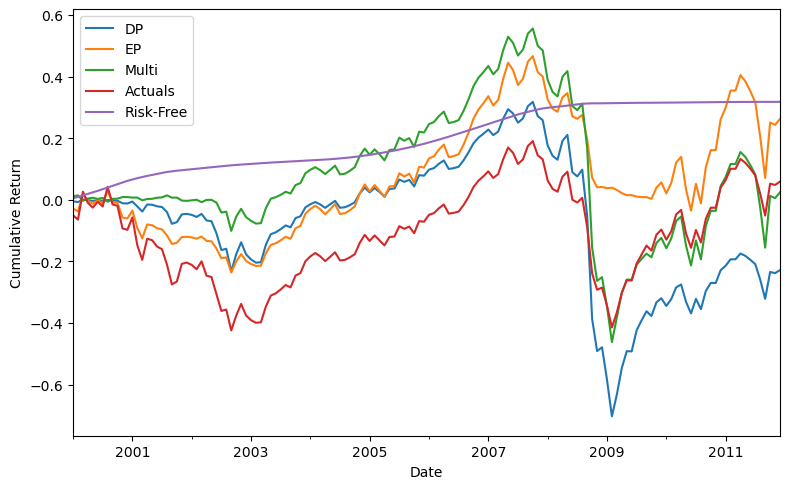

In [113]:
#from 2023
#risk-free rate added
forecast_model['Risk-Free'] = forecast_df['Risk-Free']
#limited to 2000-2011:
forecast_sub = forecast_model.loc['2000':'2011']
display(performance(forecast_sub))

#calculate cumulative returns and plot it:
forecast_sub_cum = (forecast_sub + 1).cumprod() - 1

fig, ax = plt.subplots(figsize=(8, 5))
forecast_sub_cum.plot(ax=ax)
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
fig.tight_layout()

We can see from the graph that except for the risk-free rate, all others show significant fluctuations and have periods of negative returns. Especially during the 2008 financial crisis, they had their max drawdowns. However, the risk-free rate is always steady and has a positive cumulative return over this period. Comparing other portfolios with the risk-free rate, we note that all their cumulative returns are below the risk-free rate during 2001-2005 and 2008-2011. We may say that the Multi and EP outperform the risk-free rate a little bit, but DP and Actuals do underperform it.

### Question 4

In [114]:
# from 2023
# count the negative periods and calculate the percentage
neg_count = (forecast_df < 0).sum().to_frame('Count')
neg_count['Percentage'] = neg_count / len(forecast_df)
display(neg_count)

,Count,Percentage
Mean,1,0.003086
DP,0,0.000000
EP,8,0.024691
Multi,36,0.111111
Actuals,118,0.364198
Risk-Free,0,0.000000


### Question 5

In [127]:
display(performance(df_r[['GMWAX']]))

y=df_r['GMWAX']
X=df_r['SPY']
result = sm.OLS(y, sm.add_constant(X),missing='drop').fit()
print(f' Alpha: {result.params[0]*12:.4f}, Beta: {result.params[1]:.4f}, R^2: {result.rsquared:.4f}')

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,min(max_drawdown),max,recovery,5th quantile
GMWAX,0.049936,0.112781,0.442772,2001-09-30,1997-09-30,2004-12-31,-0.046516


 Alpha: -0.0058, Beta: 0.5527, R^2: 0.5854


Comparing with the data in question 2, 

Vol: GMWAX has lower vol compared to others. Meanwhile, DP has the highest volatility (and the worst max drawdown), implying higher risk.
    
Sharpe: GMWAX, DP, and Multi all have low Sharpe ratios; while EP has the greatest Sharpe ratio and thus outperforms others.
    
Beta: $r^X$ all have high betas, suggesting that they are much more sensitive to market movements compared to GMWAX.
    
So we would say the increased risk might be behind $r^X$, especially DP, but it's not the primary reason for the outperformance of GMWAX because of its low volatility and beta.